In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [ ]:
def set_up_train_nn(P,EsNodB):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)


    # Defined Autoencoder
    batch_size = 1024
    
    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(8, activation='relu')(encoded)
    encoded2 = Dense(4, activation='relu')(encoded)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #adding channel noise
    encoded4 = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(encoded3)


    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded4)
    
    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded4)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,1), 0,np.sqrt(0.1))[0:tf.shape(x)[0]])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(2, activation='linear')(data_split)
    decoded = Dense(4, activation='relu')(data_split)
    decoded = Dense(8, activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.1)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=200,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(75000, 16)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2)            4           dense_4[0][0]                    
_________________________

75000/75000 [==============================] - 1s 7us/step - loss: 1.6029 - acc: 0.3095 - mean_squared_error: 0.0460
Epoch 36/200
75000/75000 [==============================] - 1s 7us/step - loss: 1.5978 - acc: 0.3100 - mean_squared_error: 0.0459
Epoch 37/200
75000/75000 [==============================] - 1s 7us/step - loss: 1.5987 - acc: 0.3106 - mean_squared_error: 0.0458
Epoch 38/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.6009 - acc: 0.3098 - mean_squared_error: 0.0459
Epoch 39/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.5950 - acc: 0.3115 - mean_squared_error: 0.0457
Epoch 40/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.6098 - acc: 0.3057 - mean_squared_error: 0.0460
Epoch 41/200
75000/75000 [==============================] - 1s 7us/step - loss: 1.5918 - acc: 0.3116 - mean_squared_error: 0.0456
Epoch 42/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.5901 - acc: 0.3112 - 

75000/75000 [==============================] - 1s 8us/step - loss: 1.5977 - acc: 0.3102 - mean_squared_error: 0.0457
Epoch 99/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.6050 - acc: 0.3079 - mean_squared_error: 0.0458
Epoch 100/200
75000/75000 [==============================] - 1s 7us/step - loss: 1.5964 - acc: 0.3120 - mean_squared_error: 0.0456
Epoch 101/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.6041 - acc: 0.3100 - mean_squared_error: 0.0458
Epoch 102/200
75000/75000 [==============================] - 1s 7us/step - loss: 1.6315 - acc: 0.3005 - mean_squared_error: 0.0464
Epoch 103/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.6051 - acc: 0.3096 - mean_squared_error: 0.0459
Epoch 104/200
75000/75000 [==============================] - 1s 8us/step - loss: 1.6050 - acc: 0.3082 - mean_squared_error: 0.0458
Epoch 105/200
75000/75000 [==============================] - 1s 7us/step - loss: 1.6019 - acc: 0.3

75000/75000 [==============================] - 1s 11us/step - loss: 1.6103 - acc: 0.3102 - mean_squared_error: 0.0459
Epoch 161/200
75000/75000 [==============================] - 1s 11us/step - loss: 1.5865 - acc: 0.3134 - mean_squared_error: 0.0454
Epoch 162/200
75000/75000 [==============================] - 1s 10us/step - loss: 1.5958 - acc: 0.3125 - mean_squared_error: 0.0456
Epoch 163/200
75000/75000 [==============================] - 1s 12us/step - loss: 1.5996 - acc: 0.3084 - mean_squared_error: 0.0458
Epoch 164/200
75000/75000 [==============================] - 1s 11us/step - loss: 1.5959 - acc: 0.3122 - mean_squared_error: 0.0456
Epoch 165/200
75000/75000 [==============================] - 1s 14us/step - loss: 1.5908 - acc: 0.3133 - mean_squared_error: 0.0456
Epoch 166/200
75000/75000 [==============================] - 1s 12us/step - loss: 1.6083 - acc: 0.3094 - mean_squared_error: 0.0459
Epoch 167/200
75000/75000 [==============================] - 1s 12us/step - loss: 1.6219 -

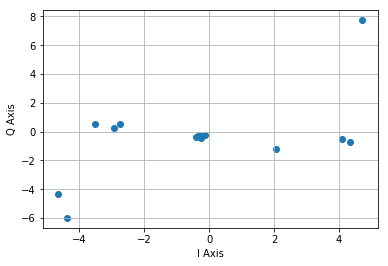

[15.625101]
Es/No: 12 SER: 0.6949066666666667 Theor_SER_PAM: 0.5075803579279314
(60000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           272         input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            34          dense_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2)            4           dense_12[0][0]                   
_________________

60000/60000 [==============================] - 1s 10us/step - loss: 1.4442 - acc: 0.3704 - mean_squared_error: 0.0427
Epoch 39/200
60000/60000 [==============================] - 1s 10us/step - loss: 1.4273 - acc: 0.3755 - mean_squared_error: 0.0422
Epoch 40/200
60000/60000 [==============================] - 1s 13us/step - loss: 1.4394 - acc: 0.3690 - mean_squared_error: 0.0427
Epoch 41/200
60000/60000 [==============================] - 1s 12us/step - loss: 1.4484 - acc: 0.3673 - mean_squared_error: 0.0428
Epoch 42/200
60000/60000 [==============================] - 1s 14us/step - loss: 1.4470 - acc: 0.3697 - mean_squared_error: 0.0426
Epoch 43/200
60000/60000 [==============================] - 1s 14us/step - loss: 1.4260 - acc: 0.3755 - mean_squared_error: 0.0423
Epoch 44/200
60000/60000 [==============================] - 1s 18us/step - loss: 1.4296 - acc: 0.3743 - mean_squared_error: 0.0423
Epoch 45/200
60000/60000 [==============================] - 1s 16us/step - loss: 1.4229 - acc: 0

60000/60000 [==============================] - 1s 10us/step - loss: 1.4179 - acc: 0.3763 - mean_squared_error: 0.0420
Epoch 101/200
60000/60000 [==============================] - 1s 15us/step - loss: 1.4238 - acc: 0.3752 - mean_squared_error: 0.0421
Epoch 102/200
60000/60000 [==============================] - 1s 10us/step - loss: 1.4185 - acc: 0.3781 - mean_squared_error: 0.0419
Epoch 103/200
60000/60000 [==============================] - 1s 11us/step - loss: 1.4395 - acc: 0.3708 - mean_squared_error: 0.0425
Epoch 104/200
60000/60000 [==============================] - 1s 14us/step - loss: 1.4266 - acc: 0.3764 - mean_squared_error: 0.0420
Epoch 105/200
60000/60000 [==============================] - 1s 14us/step - loss: 1.4571 - acc: 0.3635 - mean_squared_error: 0.0429
Epoch 106/200
60000/60000 [==============================] - 1s 14us/step - loss: 1.4202 - acc: 0.3744 - mean_squared_error: 0.0420
Epoch 107/200
60000/60000 [==============================] - 1s 12us/step - loss: 1.4179 -

60000/60000 [==============================] - 1s 10us/step - loss: 1.4247 - acc: 0.3751 - mean_squared_error: 0.0421
Epoch 163/200
60000/60000 [==============================] - 1s 10us/step - loss: 1.4210 - acc: 0.3751 - mean_squared_error: 0.0420
Epoch 164/200
60000/60000 [==============================] - 1s 10us/step - loss: 1.4306 - acc: 0.3721 - mean_squared_error: 0.0423
Epoch 165/200
60000/60000 [==============================] - 1s 11us/step - loss: 1.4600 - acc: 0.3599 - mean_squared_error: 0.0432
Epoch 166/200
60000/60000 [==============================] - 1s 11us/step - loss: 1.4833 - acc: 0.3549 - mean_squared_error: 0.0435
Epoch 167/200
60000/60000 [==============================] - 1s 11us/step - loss: 1.4298 - acc: 0.3706 - mean_squared_error: 0.0422
Epoch 168/200
60000/60000 [==============================] - 1s 11us/step - loss: 1.4373 - acc: 0.3704 - mean_squared_error: 0.0425
Epoch 169/200
60000/60000 [==============================] - 1s 9us/step - loss: 1.4143 - 

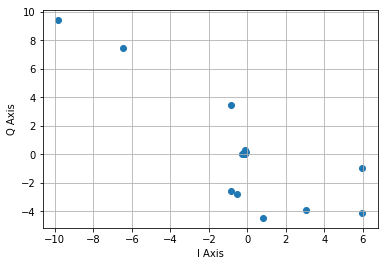

[27.776924]
Es/No: 14 SER: 0.6552166666666667 Theor_SER_PAM: 0.4143940207176103
(65000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           272         input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 2)            34          dense_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2)            4           dense_20[0][0]                   
_________________

65000/65000 [==============================] - 0s 6us/step - loss: 1.7709 - acc: 0.2397 - mean_squared_error: 0.0491
Epoch 40/200
65000/65000 [==============================] - 0s 6us/step - loss: 1.7990 - acc: 0.2301 - mean_squared_error: 0.0497
Epoch 41/200
65000/65000 [==============================] - 0s 6us/step - loss: 1.7834 - acc: 0.2344 - mean_squared_error: 0.0494
Epoch 42/200
65000/65000 [==============================] - 0s 6us/step - loss: 1.7823 - acc: 0.2332 - mean_squared_error: 0.0494
Epoch 43/200
65000/65000 [==============================] - 0s 6us/step - loss: 1.7870 - acc: 0.2301 - mean_squared_error: 0.0495
Epoch 44/200
65000/65000 [==============================] - 0s 5us/step - loss: 1.7670 - acc: 0.2371 - mean_squared_error: 0.0491
Epoch 45/200
65000/65000 [==============================] - 0s 5us/step - loss: 1.7840 - acc: 0.2336 - mean_squared_error: 0.0494
Epoch 46/200
65000/65000 [==============================] - 0s 6us/step - loss: 1.7786 - acc: 0.2385 - 

65000/65000 [==============================] - 0s 6us/step - loss: 1.6808 - acc: 0.2603 - mean_squared_error: 0.0483
Epoch 103/200
65000/65000 [==============================] - 0s 6us/step - loss: 1.6654 - acc: 0.2676 - mean_squared_error: 0.0480
Epoch 104/200
65000/65000 [==============================] - 0s 7us/step - loss: 1.6668 - acc: 0.2683 - mean_squared_error: 0.0480
Epoch 105/200
65000/65000 [==============================] - 0s 7us/step - loss: 1.6166 - acc: 0.2705 - mean_squared_error: 0.0480
Epoch 106/200
65000/65000 [==============================] - 1s 8us/step - loss: 1.6154 - acc: 0.2702 - mean_squared_error: 0.0480
Epoch 107/200
65000/65000 [==============================] - 0s 8us/step - loss: 1.6075 - acc: 0.2735 - mean_squared_error: 0.0477
Epoch 108/200
65000/65000 [==============================] - 0s 7us/step - loss: 1.6133 - acc: 0.2725 - mean_squared_error: 0.0479
Epoch 109/200
65000/65000 [==============================] - 0s 7us/step - loss: 1.6134 - acc: 0.

In [ ]:
EsNodB_range = [12,14,16,20,25,26]
N_array=[75000,60000,65000,12000,10000,14000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

noise_std = np.sqrt(1.1)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    # generating data for checking SER
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_PAM:',theor_ser[n])
    

In [ ]:
plt.plot(EsNodB_range, theor_ser, 'g--',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Conventional PD-both streams')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [ ]:
ser